# Project structure:

```
stockai
├── __init__.py
├── __main__.py
├── app.py
├── config
│   ├── __init__.py
│   └── config.py
├── data_collection
│   ├── __init__.py
│   ├── extract_text.py
│   ├── extract_urls.py
│   ├── geckodriver
│   ├── logs
│   │   ├── extract_urls.log
│   │   └── multi_text_extraction.log
│   ├── newsapi.py
│   └── stocknewsapi_com.py
├── data_prep
│   └── fix_date.py
└── ml
    └── __init__.py
```

## Data Collection

> **The data collection happens outside of this notebook in the files described below. The data isn't stored in github.**

1. `data_collection/extract_urls.py` extracts URLs for news articles related to S&P500 companies. 
    1. Main sources:
        1. Yahoo news
        2. finviz.com
        3. *usanews* subreddit
    2. Additional sources:
        1. `newsapi.py` Newsapi and 20+ media outlets
        2. `stocknewsapi_com.py` convenient source of URLs from February 2018+
2. `data_collection/extract_text.py` visits URLs collected on the previous step and extracts text from the articles. **Data quality assurance** steps:
    1. Use Selenium Firefox driver to get JS article content from webpages.
    2. Use *outline.com* engine to go through paywalls
    3. Use original URL to extract HTML if outline fails
    4. Pass *html* to *Newspaper3K* package to extract text and meta data checking the length of article (>200 words)
    5. Strip text from extra symbols and save to DB: `" ".join(re.split(r'[\n\t]+'`
    
URLs and data are stored in **MongoDB**

## Data Cleaning and Dataset Creation

In [54]:
from ipywidgets import IntProgress
from IPython.display import display

def clean_and_tokenize_text(text):
    """
    Cleans `text` from punctuation and special symbols
    """    
    # need to adjust this for better cleaning
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import stopwords

    lower_alpha_tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
    no_stop = [t for t in lower_alpha_tokens if t not in set(stopwords.words('english'))]
    
    wnl = WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(t) for t in no_stop]
    return lemmatized

def quality_check(article):
    """
    Checks for quality of the `article` and returns False if it doesnt' pass the 
    QA check
    """
    
    # need to find ways for better QA
    if article and len(article.split()) > 200: return True
    return False

def concat_news(c, ticker, start_date=None, end_date=None, period=1):
    """
    Reads all news from the `DB` for the `ticker`, 
    concats by the `period`.
    
    Input
    -----
    c     : collection, MongoDB
    ticker: str, ticker name
    period: int, default 1 (day)
    
    Output
    ------
    resulting_dictionary: dict, key–day, value–all news for that day
    Counter(all_tokens)
    """
    from collections import Counter
    
    news = c.find_one({
        'ticker' : ticker
    })['news']
    
    resulting_dictionary = {}
    
    all_tokens = []
    
    i = 0 # counter for missing dates
    
    print(f'Concatenating news for {ticker}')
    f = IntProgress(min=0, max=len(news)) # instantiate the bar
    display(f)
    
    for n in news:
        f.value += 1
        try:
            date = pd.to_datetime(n['datetime']).date()
            
            if date < start_date or date > end_date: continue

            tokens = clean_and_tokenize_text(n['text'])

            text = ' '.join(tokens)

            all_tokens.extend(tokens)

            if quality_check(text):
                if str(date) in resulting_dictionary.keys():
                    resulting_dictionary[str(date)] = resulting_dictionary[str(date)] + text
                else:
                    resulting_dictionary[date] = text
        except Exception as e:
            i += 1
#             print(f"Cannot process url: {n['url']}\nError: {e}")
    
    print(f'{i} articles out of {len(news)} or {round(i/len(news),2)}% did not have dates. ')
    
    return resulting_dictionary, Counter(all_tokens)

from yahoo_fin import stock_info as si 
import pandas as pd
from datetime import date


def create_dataset(c, ticker=None, start_date=None, end_date=None):
    """
    Creating dataset for predicting pricing for a company
    
    Input
    -----
    c    : MongoDB collection
    """
    if end_date == None: 
        end_date = date.today()
    else:
        end_date = pd.to_datetime(end_date).date()
        
    if start_date == None:
        start_date = pd.to_datetime('2020-06-01').date()
    else:
        start_date = pd.to_datetime(start_date).date()
        
    if ticker == None: ticker = 'AAPL'

    # Obtain historical stock pricing data
    t_data = si.get_data(ticker, start_date=start_date, end_date=end_date)
    
    # get the dictionary with all news per period (1 day) and BOW (bag of words)
    t_news, t_bow = concat_news(
        c, 
        ticker=ticker, 
        start_date=start_date,
        end_date=end_date,
        period=1)
    
    # convert to pandas df
    t_df = pd.DataFrame.from_dict(t_news, orient='index', columns=['text'])
    t_df.index = pd.to_datetime(t_df.index)
    
    # combine news with stock price 'adjclose'
    t_combined = pd.concat([t_df, t_data.adjclose], axis=1)
    
    # fill adjclose for over the weekends and holiday
    # logic is the price on monday close is the result of 
    # the news over the weekend hence backfill
    t_combined.adjclose = t_combined.adjclose.fillna(method='backfill')
    
    # drop rows without the stock price
    t_combined = t_combined[t_combined.adjclose.notna()]

    # drop rows without news
    t_combined = t_combined[t_combined.text.notna()]
    
    # drop rows without date
    t_combined = t_combined[t_combined.index.notna()]
    
    print(f'Total of {len(t_combined)} articles returned.')
    
    return t_combined

In [94]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm
from sklearn import tree

def try_models(X, y):
    """
    Outputing scores for different ML models
    """

    models = []

    models.append(('LogisticRegression', linear_model.LinearRegression()))
    models.append(('Ridge', linear_model.Ridge()))
    models.append(('Lasso', linear_model.Lasso(alpha=0.1)))
    models.append(('ElasticNet', linear_model.ElasticNet()))
    models.append(('DecisionTreeRegressor', tree.DecisionTreeRegressor()))
    models.append(('SVM', svm.SVR()))

    scores = dict()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)

    for name, model in models:
        interim_scores = cross_val_score(model, X_train, y_train)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores[name] = interim_scores
        print(f'''{name}
        Cross val score mean: {interim_scores.mean()}
        MSE: {mean_squared_error(y_test, y_pred)}
        R2: {r2_score(y_test, y_pred)}
        ''')

# ML Prototype

Take 1 stock (AAPL), do sentiment and compare to stock price time series

Concatenating news for AAPL


IntProgress(value=0, max=922)

39 articles out of 922 or 0.04% did not have dates. 
Total of 32 articles returned.
LogisticRegression
        Cross val score mean: -1.4429098066010262
        MSE: 8.599076136363744
        R2: 0.09636119809805088
        
Ridge
        Cross val score mean: -1.542633728919769
        MSE: 9.56859869321282
        R2: -0.005521630684354406
        
Lasso
        Cross val score mean: -1.300637683754033
        MSE: 10.67879425114369
        R2: -0.12218716171775479
        
ElasticNet
        Cross val score mean: -1.7045021265413545
        MSE: 11.101144063047537
        R2: -0.16657003168658524
        
DecisionTreeRegressor
        Cross val score mean: -3.0594578447031715
        MSE: 24.652967127371813
        R2: -1.5906710587315191
        


/Users/yegor/anaconda3/envs/springboard/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


SVM
        Cross val score mean: -2.9864859531598027
        MSE: 10.576833943296204
        R2: -0.11147260483236643
        


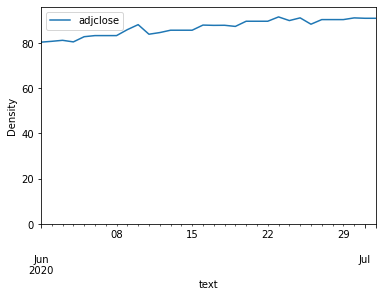

In [97]:
import pymongo as pm
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

client = pm.MongoClient('mongodb://localhost:27017')
c = client['news']['recommendations']

ticker = 'AAPL'
start_date='2020-06-01'
end_date='2020-07-03'

t_combined = create_dataset(
    c, 
    ticker=ticker, 
    start_date=start_date, 
    end_date=end_date)
t_combined.plot()

# looking at text lengths
sns.distplot(t_combined.text.apply(len))


vectorizer = TfidfVectorizer()
X, y = vectorizer.fit_transform(t_combined.text), t_combined.adjclose

try_models(X, y)

## Use time series

Text(0.5, 1.0, 'AAPL Autocorrelation plot - Lag 1')

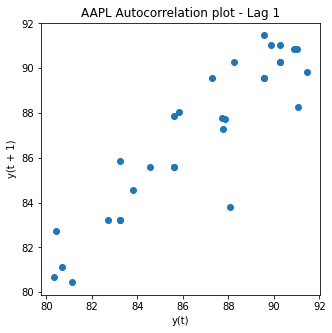

In [99]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
lag_plot(t_combined['adjclose'], lag=1)
plt.title(f'{ticker} Autocorrelation plot - Lag 1')

Text(0.5, 1.0, 'AAPL Autocorrelation plot - Lag 5')

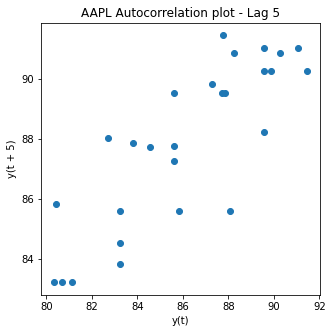

In [100]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
lag_plot(t_combined['adjclose'], lag=5)
plt.title(f'{ticker} Autocorrelation plot - Lag 5')

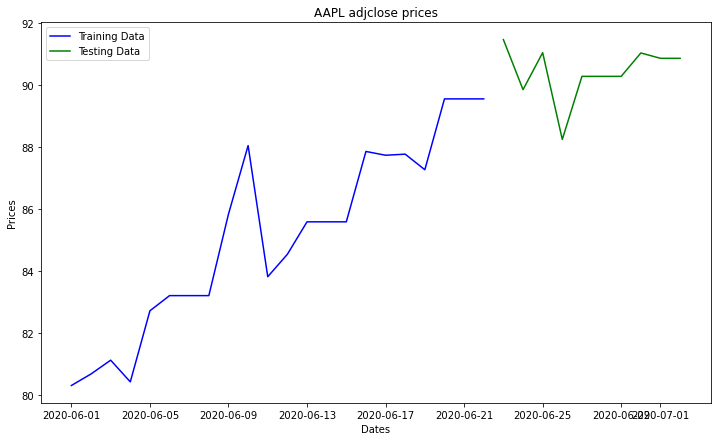

In [108]:
train_data, test_data = t_combined.iloc[0:int(len(t_combined)*0.7), :], t_combined.iloc[int(len(t_combined)*0.7):, :]

plt.figure(figsize=(12,7))
plt.title(f'{ticker} adjclose prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data.adjclose, 'blue', label='Training Data')
plt.plot(test_data.adjclose, 'green', label='Testing Data')
plt.legend();

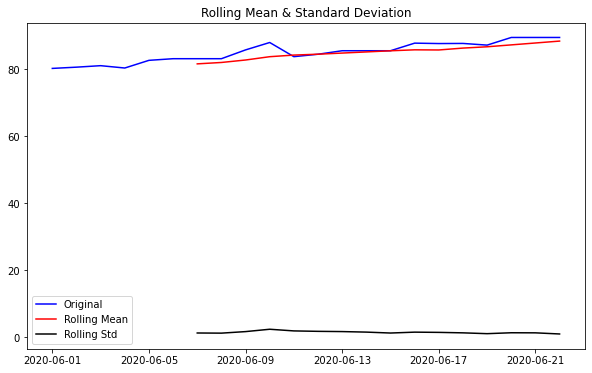

In [110]:
window = 7
train_series = train_data.adjclose

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

In [111]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  1.927379
p-value                         0.998571
#Lags Used                      9.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64

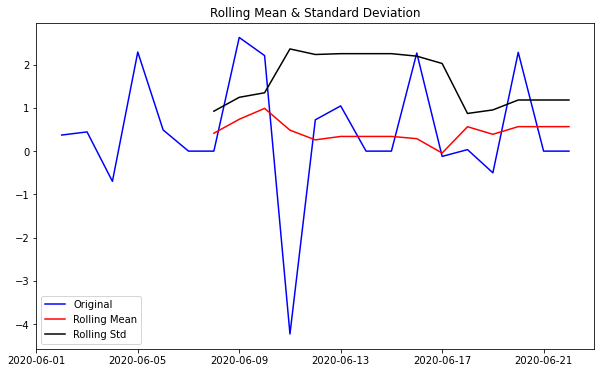

In [112]:
train_diff = train_series.diff(1)
train_diff = train_diff.dropna(inplace = False)

window = 7

rolmean = train_diff.rolling(window).mean()
rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

In [113]:
# After differencing, the p-value is < 0.05. Thus this series is very likely to be stationary.
dftest = adfuller(train_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                 -2.971869
p-value                         0.037606
#Lags Used                      8.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64

/Users/yegor/anaconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


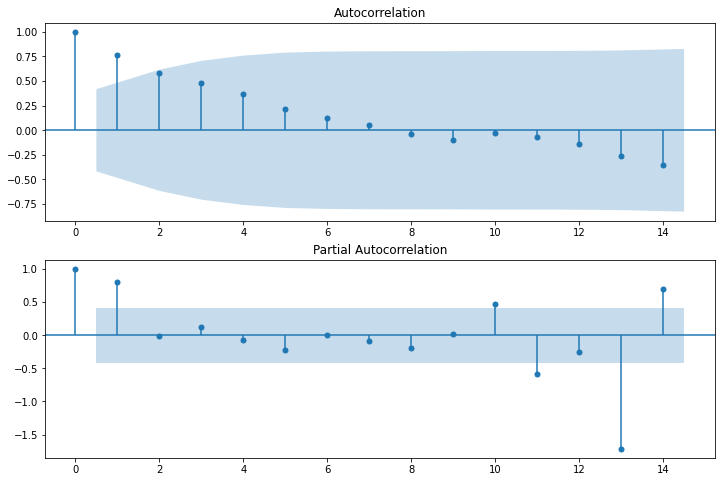

In [114]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

/Users/yegor/anaconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


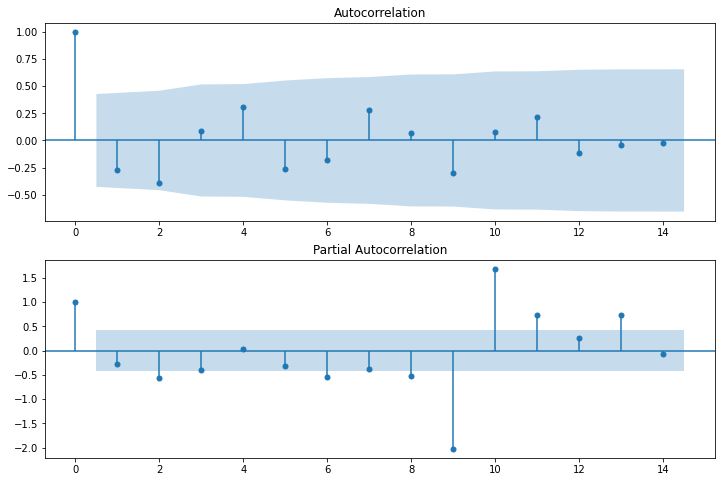

In [115]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0]); # 
plot_pacf(train_diff, ax=ax[1]);

In [124]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

test_series = test_data.adjclose
test_diff = test_series.diff(1)
test_diff = test_diff.dropna(inplace = False)

history = [x for x in train_diff]

f = IntProgress(min=0, max=len(test_diff)) # instantiate the bar
display(f)

predictions = list()
for t in range(len(test_diff)):
    f.value += 1
    model = ARIMA(history, order=(3,1,0)) 
    model_fit = model.fit() 

    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

IntProgress(value=0, max=9)

Test Series Point: 0	Predicted=0.5526017510456891, Expected=-1.6145858764648438


In [125]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

train_data, test_data = t_combined.iloc[0:int(len(t_combined)*0.7), :], t_combined.iloc[int(len(t_combined)*0.7):, :]

train_series = train_data.adjclose
test_series = test_data.adjclose
train_series.shape, test_series.shape

((22,), (10,))

[]

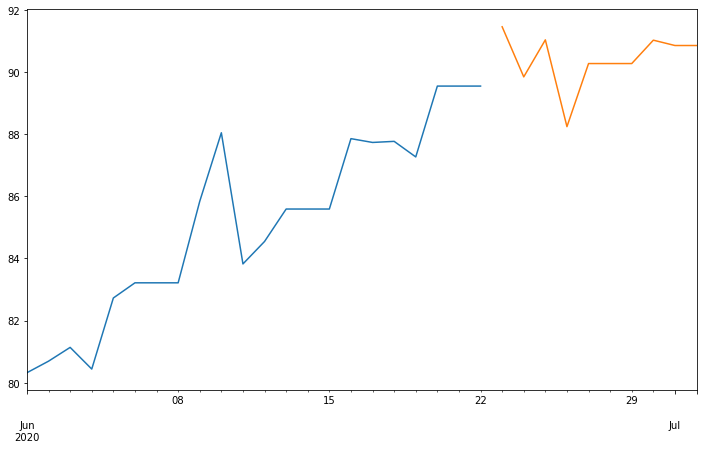

In [126]:
plt.figure(figsize=(12,7))
train_series.plot()
test_series.plot()
plt.plot()

In [127]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train_series.values.reshape(-1,1))

X_train = []
y_train = []
for i in range(3, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-3:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((19, 3), (19,))

In [128]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))
X_train.shape

(19, 3, 1)